In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np

from tensorflow import Tensor
from keras.models import Model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input

from numpy import expand_dims
from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications import VGG19

from pprint import pprint

from function.gram import gram_matrix as gr
from function.compute import gram_matrix


In [2]:
vgg19 = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
vgg19.summary()

2022-11-21 09:56:33.452849: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 09:56:33.475138: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 09:56:33.475319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-21 09:56:33.476234: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [3]:
def create_list_of_vgg_layer():

    style_layer_names   = ['block1_conv1',
                           'block2_conv1',
                           'block3_conv1',
                           'block4_conv1',
                           'block5_conv1']

    return (style_layer_names)

def load_vgg19()-> Model:
    vgg = VGG19(include_top=False, weights='imagenet')
    return vgg

def create_multi_output_model(style_layers : list)-> Model:

    vgg19 = load_vgg19()
    
    layers_name = style_layers
    layers_output = list()
    
    for name in layers_name:
        layer = vgg19.get_layer(name)
        output = layer.output
        layers_output.append(output)

    multi_output_model = Model([vgg19.input], layers_output)
    multi_output_model.trainable = False

    return (multi_output_model)

In [4]:
style_layer = create_list_of_vgg_layer()
model = create_multi_output_model(style_layer)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [5]:
img = load_img('img/style/waves.png')
img = img_to_array(img)
img = expand_dims(img, axis=0)
input = preprocess_input(img)
input.shape

(1, 892, 874, 3)

In [6]:
feature_maps = model.predict(input)
for f in feature_maps :
    print(f.shape)
print(len(feature_maps))

2022-11-21 09:56:36.417222: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8600
2022-11-21 09:56:37.041076: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.69GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-11-21 09:56:37.041132: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.69GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-11-21 09:56:37.718903: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.56GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory

(1, 892, 874, 64)
(1, 446, 437, 128)
(1, 223, 218, 256)
(1, 111, 109, 512)
(1, 55, 54, 512)
5


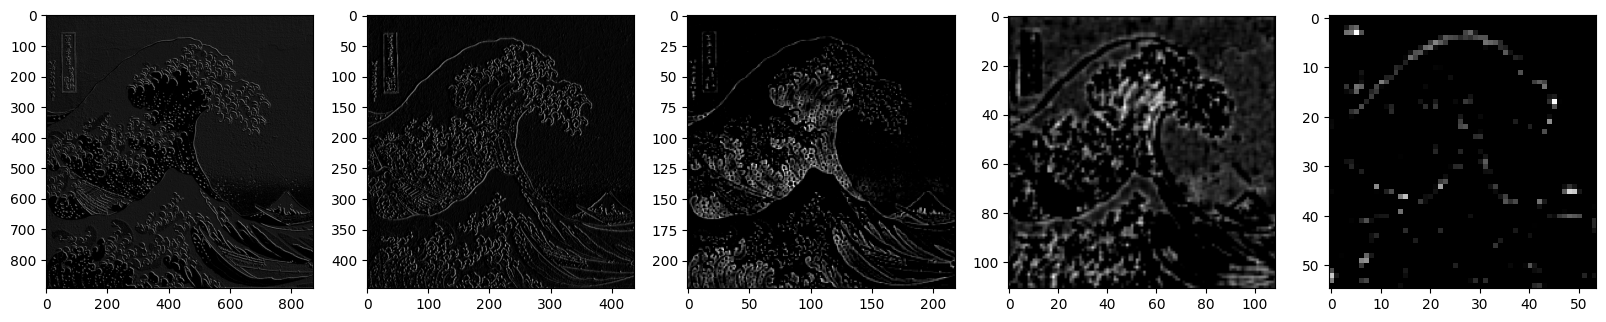

In [7]:
fig, ax = plt.subplots(1, 5, figsize=(20, 15))

i = 0
for f in feature_maps :
    ax[i].imshow(f[0, :, :, 4], cmap='gray')
    i += 1

In [8]:
def flatten_filters(Filters):
    
    batch = int(Filters.shape[0])
    vector_pixels = int(Filters.shape[1] * Filters.shape[2])
    nbr_filter = int(Filters.shape[3])
    
    matrix_pixels = tf.reshape(Filters, (batch, vector_pixels, nbr_filter))
    return (matrix_pixels)

def normalize_matrix(G, Filters):

    height =  tf.cast(Filters.shape[1], tf.float32)
    width =  tf.cast(Filters.shape[2], tf.float32)
    number_pixels = height * width
    G = G / number_pixels
    return (G)
 
def gram_matrix(Filters):

    F = flatten_filters(Filters)
    Gram = tf.matmul(F, F, transpose_a=True)
    Gram = normalize_matrix(Gram, Filters)
    return Gram


In [9]:
# fig, ax = plt.subplots(figsize=(10,10)) 
# gram = gram_matrix(feature_maps[4])
# matrix = tf.reshape(gram, (gram.shape[1], gram.shape[2]))
# sns.heatmap(matrix, ax=ax)

In [10]:
# fig, ax = plt.subplots(5, 1, figsize=(20, 10))
# i = 0
# for f in feature_maps:
#     gram = gram_matrix(f)
#     matrix = tf.reshape(gram, (gram.shape[1], gram.shape[2]))
#     sns.heatmap(matrix, ax=ax[i])
#     i += 1
#     # b = tf.reshape(Gram, (Gram.shape[1], Gram.shape[2], Gram.shape[0]))
#     # plt.imshow(b)

In [11]:
# # print(feature_maps[0].shape)
# from time import time

# start = time()
# gram = gr(feature_maps[0])
# end = time()
# print("{:.6f} seconds".format(end-start))
# start = time()
# grams = gram_matrix(feature_maps[0])
# end = time()
# print("{:.6f} seconds".format(end-start))
# print(int(tf.reduce_mean(gram - grams)))
# print(int(tf.reduce_mean(grams - gram)))

In [17]:
def plot_features_map(features_map):
    # plot the output from each block
    height = 2
    width = 2

    for map in feature_maps:
        # plot all 64 maps in an 8x8 squares
        place = 1
        for _ in range(height):
            for _ in range(width):
                # specify subplot and turn of axis
                ax = plt.subplot(height, width, place)
                ax.set_xticks([])
                ax.set_yticks([])
                # plot filter channel in grayscale
                plt.imshow(map[0, :, :, place-1])
                place += 1
        # show the figure
        plt.show()

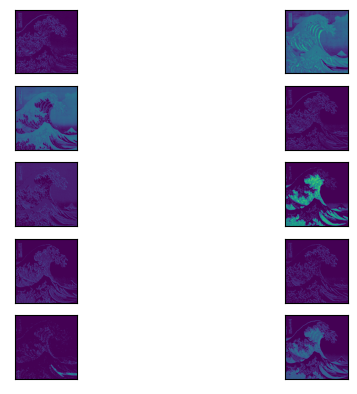

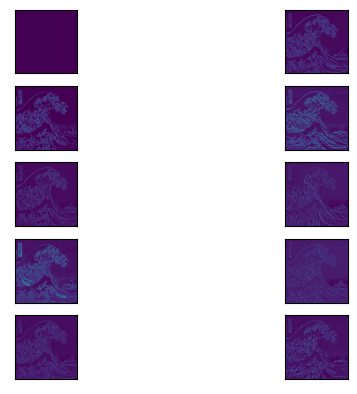

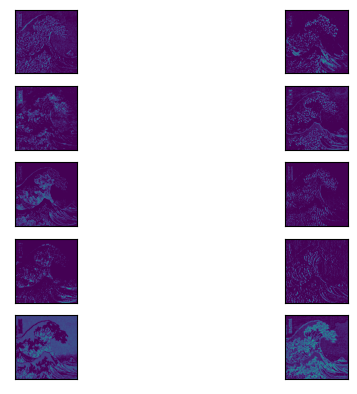

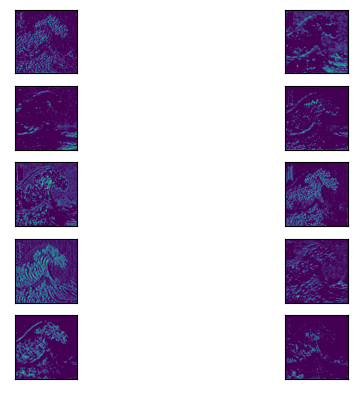

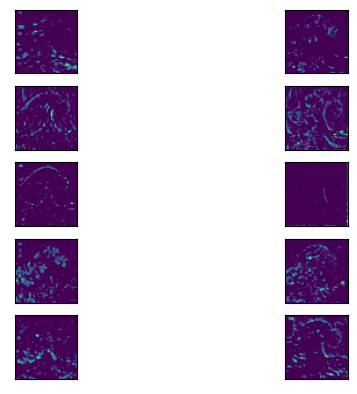

In [18]:
plot_features_map(feature_maps)

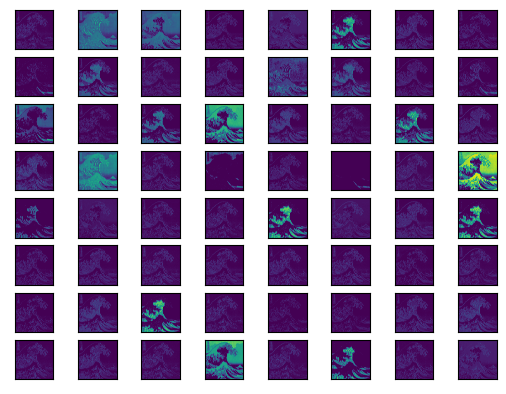

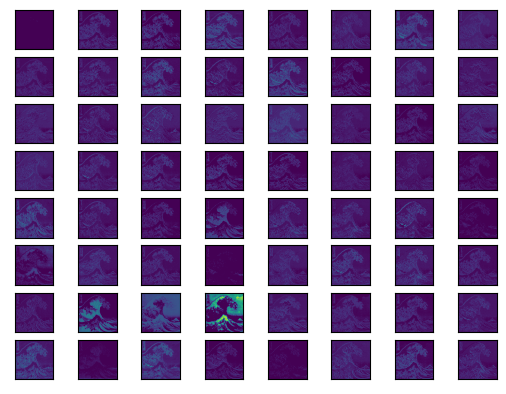

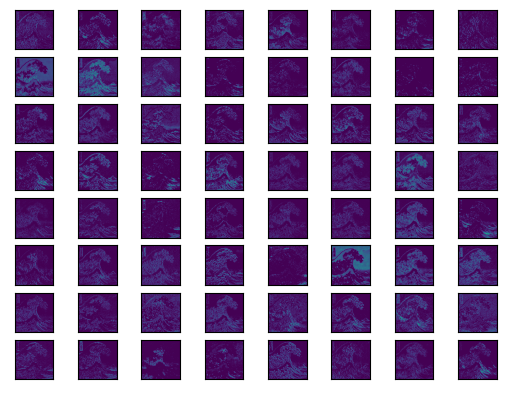

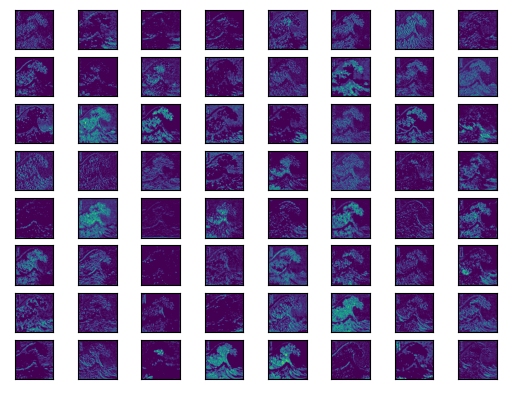

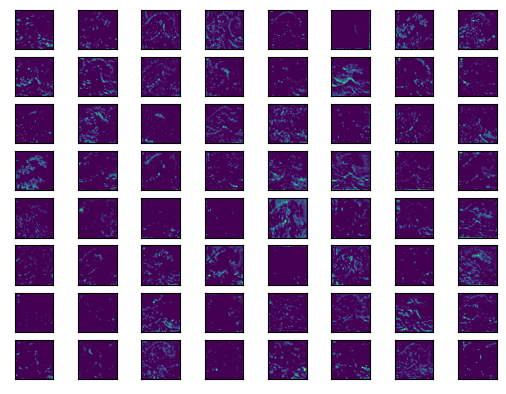

In [14]:
# plot the output from each block
height = 8
width = 8

for map in feature_maps:
   # plot all 64 maps in an 8x8 squares
   place = 1
   for _ in range(height):
      for _ in range(width):
         # specify subplot and turn of axis
         ax = plt.subplot(height, width, place)
         ax.set_xticks([])
         ax.set_yticks([])
         # plot filter channel in grayscale
         plt.imshow(map[0, :, :, place-1])
         place += 1
   # show the figure
   plt.show()